In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import torch
from torch_rbm import RBM as TRBM
import datetime
from softmax import Net, train
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_kddcup99

In [20]:
data = fetch_kddcup99(percent10 = False) # takes a few minutes
print(data.data.shape)


(4898431, 41)


In [21]:
X, y = data.data, data.target

In [22]:
X, X_val, y, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
del data

In [ ]:
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate"
]

df_train = pd.DataFrame(X, columns=columns)
df_val = pd.DataFrame(X_val, columns=columns)

categorical_cols = ["protocol_type", "service", "flag"]
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df_train[categorical_cols])
cat_train = encoder.transform(df_train[categorical_cols])
cat_val = encoder.transform(df_val[categorical_cols])

numeric_cols = [col for col in columns if col not in categorical_cols]
num_train = df_train[numeric_cols].astype(float).values
num_val = df_val[numeric_cols].astype(float).values

# standardization
scaler = StandardScaler()
num_train_std = scaler.fit_transform(num_train)
num_val_std = scaler.transform(num_val)

# normalization
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
num_train_norm = minmax_scaler.fit_transform(num_train_std)
num_val_norm = minmax_scaler.transform(num_val_std)

X = np.hstack([cat_train, num_train_norm])
X_val = np.hstack([cat_val, num_val_norm])
del num_train, num_val, num_train_std, num_val_std, num_train_norm, df_train, df_val


NameError: name 'num_val' is not defined

In [7]:
del df_train, df_val

In [24]:
def map_label(label):
    if label == b"normal.":
        return 0
    else:
        return 1
    
y = np.array([map_label(lbl) for lbl in y])
y_val = np.array([map_label(lbl) for lbl in y_val])

In [28]:
# X_train_tensor = torch.tensor(X, dtype=torch.double)
Y_train_tensor = torch.tensor(np.array(y), dtype=torch.long) 
# X_val_tensor = torch.tensor(X_val, dtype=torch.double)
Y_val_tensor = torch.tensor(np.array(y_val), dtype=torch.long) 
batch_size = 64

In [10]:
del X, y, X_val, y_val

In [11]:
device = 'cpu'
input_size = X_train_tensor.shape[1] # 122
rbm = TRBM(input_size, 50, device)
rbm = rbm.to(device)
print(datetime.datetime.now())
print("Training RBM using the original RBM code...")
rbm.fit(X_train_tensor, iterations=20, learning_rate=0.01, cd_n=1, batch_size=256, verbose=True)
print("RBM training complete.")
print(datetime.datetime.now())

2025-06-02 20:49:08.865632
Training RBM using the original RBM code...
Iteration: 1 of 20
Iteration: 2 of 20
Iteration: 3 of 20
Iteration: 4 of 20
Iteration: 5 of 20
Iteration: 6 of 20
Iteration: 7 of 20
Iteration: 8 of 20
Iteration: 9 of 20
Iteration: 10 of 20
Iteration: 11 of 20
Iteration: 12 of 20
Iteration: 13 of 20
Iteration: 14 of 20
Iteration: 15 of 20
Iteration: 16 of 20
Iteration: 17 of 20
Iteration: 18 of 20
Iteration: 19 of 20
Iteration: 20 of 20
RBM training complete.
2025-06-02 21:13:59.585470


In [12]:
H_train_tensor = rbm.draw_hidden(X_train_tensor)
H_val_tensor = rbm.draw_hidden(X_val_tensor)

In [13]:
device = 'cpu'
rbm2 = TRBM(50, 50, device)
rbm2 = rbm2.to(device)
print(datetime.datetime.now())
print("Training RBM using the original RBM code...")
rbm2.fit(H_train_tensor, iterations=20, learning_rate=0.01, cd_n=1, batch_size=256, verbose=True)
print("RBM training complete.")
print(datetime.datetime.now())

2025-06-02 21:15:52.200164
Training RBM using the original RBM code...
Iteration: 1 of 20
Iteration: 2 of 20
Iteration: 3 of 20
Iteration: 4 of 20
Iteration: 5 of 20
Iteration: 6 of 20
Iteration: 7 of 20
Iteration: 8 of 20
Iteration: 9 of 20
Iteration: 10 of 20
Iteration: 11 of 20
Iteration: 12 of 20
Iteration: 13 of 20
Iteration: 14 of 20
Iteration: 15 of 20
Iteration: 16 of 20
Iteration: 17 of 20
Iteration: 18 of 20
Iteration: 19 of 20
Iteration: 20 of 20
RBM training complete.
2025-06-02 21:35:18.341605


In [14]:
del X_train_tensor, X_val_tensor

In [15]:
H_train_tensor = torch.tensor(rbm2.draw_hidden(H_train_tensor), dtype=torch.float)
H_val_tensor = torch.tensor(rbm2.draw_hidden(H_val_tensor), dtype=torch.float)
dataset_Train = TensorDataset(H_train_tensor, Y_train_tensor)
dataset_val = TensorDataset(H_val_tensor, Y_val_tensor)

batch_size = 64
loader_train = DataLoader(dataset_Train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

C:\Users\wikto\AppData\Local\Temp\ipykernel_15228\747792586.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_train_tensor = torch.tensor(rbm2.draw_hidden(H_train_tensor), dtype=torch.float)
C:\Users\wikto\AppData\Local\Temp\ipykernel_15228\747792586.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_val_tensor = torch.tensor(rbm2.draw_hidden(H_val_tensor), dtype=torch.float)


In [30]:
model = Net(50,2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters())
# optimizer = optim.RMSprop(model.parameters())
history_Adam = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 6.302307203469652e-06, training accuracy: 99.99834130527536
epoch: 1, validation loss: 0.0, validation accuracy: 100.0
model saved

epoch: 2, training loss: 0.0, training accuracy: 100.0
epoch: 2, validation loss: 0.0, validation accuracy: 100.0

epoch: 3, training loss: 0.0, training accuracy: 100.0
epoch: 3, validation loss: 0.0, validation accuracy: 100.0

epoch: 4, training loss: 0.0, training accuracy: 100.0
epoch: 4, validation loss: 0.0, validation accuracy: 100.0

epoch: 5, training loss: 0.0, training accuracy: 100.0
epoch: 5, validation loss: 0.0, validation accuracy: 100.0

epoch: 6, training loss: 0.0, training accuracy: 100.0
epoch: 6, validation loss: 0.0, validation accuracy: 100.0

epoch: 7, training loss: 0.0, training accuracy: 100.0
epoch: 7, validation loss: 0.0, validation accuracy: 100.0

epoch: 8, training loss: 0.0, training accuracy: 100.0
epoch: 8, validation loss: 0.0, validation accuracy: 100.0

epoch: 9, training loss: 0.0, training

In [31]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
optimizer = optim.SGD(model.parameters())
# optimizer = optim.RMSprop(model.parameters())
history_SGD = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 6.855383038013604e-05, training accuracy: 99.91915777095927
epoch: 1, validation loss: 6.998001879053111e-06, validation accuracy: 100.0
model saved

epoch: 2, training loss: 4.864481693516265e-06, training accuracy: 100.0
epoch: 2, validation loss: 3.5144281933620827e-06, validation accuracy: 100.0
model saved

epoch: 3, training loss: 2.856276959448377e-06, training accuracy: 100.0
epoch: 3, validation loss: 2.349832650273074e-06, validation accuracy: 100.0
model saved

epoch: 4, training loss: 2.0317602015870113e-06, training accuracy: 100.0
epoch: 4, validation loss: 1.7661513205976723e-06, validation accuracy: 100.0
model saved

epoch: 5, training loss: 1.578929067154784e-06, training accuracy: 100.0
epoch: 5, validation loss: 1.4149677724992268e-06, validation accuracy: 100.0
model saved

epoch: 6, training loss: 1.2923531301365094e-06, training accuracy: 100.0
epoch: 6, validation loss: 1.1814474235983113e-06, validation accuracy: 100.0
model saved

epoc

In [32]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters())
optimizer = optim.RMSprop(model.parameters())
history_RMS = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 2.464393504784342e-07, training accuracy: 99.99956618753356
epoch: 1, validation loss: 0.0, validation accuracy: 100.0
model saved

epoch: 2, training loss: 0.0, training accuracy: 100.0
epoch: 2, validation loss: 0.0, validation accuracy: 100.0

epoch: 3, training loss: 0.0, training accuracy: 100.0
epoch: 3, validation loss: 0.0, validation accuracy: 100.0

epoch: 4, training loss: 0.0, training accuracy: 100.0
epoch: 4, validation loss: 0.0, validation accuracy: 100.0

epoch: 5, training loss: 0.0, training accuracy: 100.0
epoch: 5, validation loss: 0.0, validation accuracy: 100.0

epoch: 6, training loss: 0.0, training accuracy: 100.0
epoch: 6, validation loss: 0.0, validation accuracy: 100.0

epoch: 7, training loss: 0.0, training accuracy: 100.0
epoch: 7, validation loss: 0.0, validation accuracy: 100.0

epoch: 8, training loss: 0.0, training accuracy: 100.0
epoch: 8, validation loss: 0.0, validation accuracy: 100.0

epoch: 9, training loss: 0.0, training

In [33]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters())
optimizer = optim.Adagrad(model.parameters())
history_Adagrad = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 4.628450371282036e-06, training accuracy: 99.99946411401204
epoch: 1, validation loss: 4.6889751736199485e-07, validation accuracy: 100.0
model saved

epoch: 2, training loss: 3.2565567773005056e-07, training accuracy: 100.0
epoch: 2, validation loss: 2.3522753159000052e-07, validation accuracy: 100.0
model saved

epoch: 3, training loss: 1.9096682155242677e-07, training accuracy: 100.0
epoch: 3, validation loss: 1.5700199464692464e-07, validation accuracy: 100.0
model saved

epoch: 4, training loss: 1.3571112038235713e-07, training accuracy: 100.0
epoch: 4, validation loss: 1.1800431166964575e-07, validation accuracy: 100.0
model saved

epoch: 5, training loss: 1.0540769356089127e-07, training accuracy: 100.0
epoch: 5, validation loss: 9.48119087067104e-08, validation accuracy: 100.0
model saved

epoch: 6, training loss: 8.625196871522189e-08, training accuracy: 100.0
epoch: 6, validation loss: 7.858394281911698e-08, validation accuracy: 100.0
model saved

epo

In [34]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters())
optimizer = optim.NAdam(model.parameters())
history_NAdam = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 3.746715176258066e-06, training accuracy: 99.99785645604817
epoch: 1, validation loss: 0.0, validation accuracy: 100.0
model saved

epoch: 2, training loss: 0.0, training accuracy: 100.0
epoch: 2, validation loss: 0.0, validation accuracy: 100.0

epoch: 3, training loss: 0.0, training accuracy: 100.0
epoch: 3, validation loss: 0.0, validation accuracy: 100.0

epoch: 4, training loss: 0.0, training accuracy: 100.0
epoch: 4, validation loss: 0.0, validation accuracy: 100.0

epoch: 5, training loss: 0.0, training accuracy: 100.0
epoch: 5, validation loss: 0.0, validation accuracy: 100.0

epoch: 6, training loss: 0.0, training accuracy: 100.0
epoch: 6, validation loss: 0.0, validation accuracy: 100.0

epoch: 7, training loss: 0.0, training accuracy: 100.0
epoch: 7, validation loss: 0.0, validation accuracy: 100.0

epoch: 8, training loss: 0.0, training accuracy: 100.0
epoch: 8, validation loss: 0.0, validation accuracy: 100.0

epoch: 9, training loss: 0.0, training

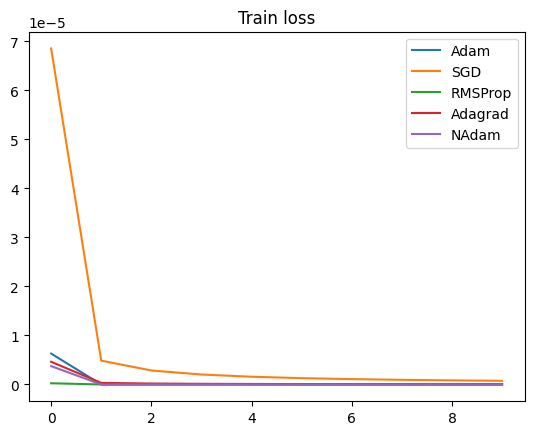

In [35]:
plt.plot(history_Adam['loss_train'], label='Adam')
plt.plot(history_SGD['loss_train'], label = 'SGD')
plt.plot(history_RMS['loss_train'], label = 'RMSProp')
plt.plot(history_Adagrad['loss_train'], label = 'Adagrad')
plt.plot(history_NAdam['loss_train'], label = 'NAdam')
plt.legend()
plt.title('Train loss')
plt.show()

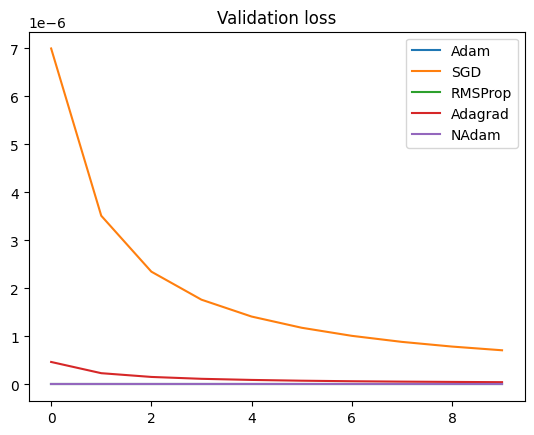

In [36]:
plt.plot(history_Adam['loss_val'], label='Adam')
plt.plot(history_SGD['loss_val'], label = 'SGD')
plt.plot(history_RMS['loss_val'], label = 'RMSProp')
plt.plot(history_Adagrad['loss_val'], label = 'Adagrad')
plt.plot(history_NAdam['loss_val'], label = 'NAdam')
plt.legend()
plt.title('Validation loss')
plt.show()

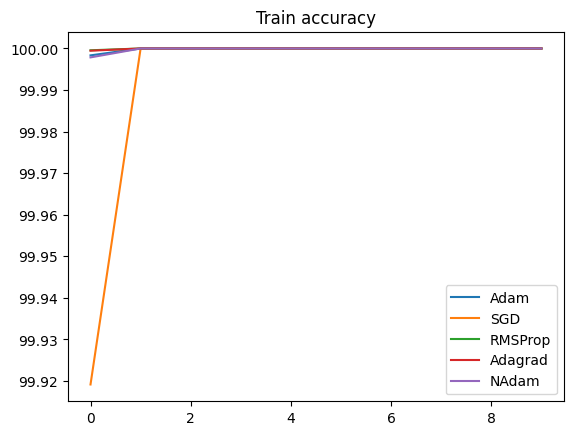

In [37]:
plt.plot(history_Adam['accuracy_train'], label='Adam')
plt.plot(history_SGD['accuracy_train'], label = 'SGD')
plt.plot(history_RMS['accuracy_train'], label = 'RMSProp')
plt.plot(history_Adagrad['accuracy_train'], label = 'Adagrad')
plt.plot(history_NAdam['accuracy_train'], label = 'NAdam')
plt.legend()
plt.title('Train accuracy')
plt.show()

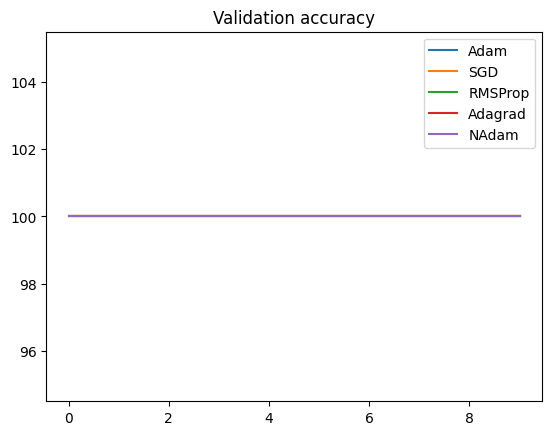

In [38]:
plt.plot(history_Adam['accuracy_val'], label='Adam')
plt.plot(history_SGD['accuracy_val'], label = 'SGD')
plt.plot(history_RMS['accuracy_val'], label = 'RMSProp')
plt.plot(history_Adagrad['accuracy_val'], label = 'Adagrad')
plt.plot(history_NAdam['accuracy_val'], label = 'NAdam')
plt.legend()
plt.title('Validation accuracy')
plt.show()